# Transfer Learning with TensorFlow part 2: feature extraction

In [1]:
!nvidia-smi

Wed Aug  4 13:15:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create helper functions

In [2]:
# get the collection of help functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-04 13:15:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-04 13:15:15 (94.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Getting data
This time we are going to see how we can use the pretrained models with `tf.keras.application` and apply them to our own problem (recognizing images of food).

In [4]:
# Get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2021-08-04 13:15:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   233MB/s    in 0.7s    

2021-08-04 13:15:18 (233 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
# Creating training and test dir paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   ...
   [158.648      188.86226    222.21947   ]
   [158.         188.         222.        ]
   [156.35718    189.35718    222.35718   ]]

  [[254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   ...
   [158.85716    189.07143    222.42863   ]
   [156.93365    189.93365    222.93365   ]
   [157.02551    190.02551    223.02551   ]]

  [[254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   ...
   [158.55101    190.61737    223.35721   ]
   [157.72958    190.72958    223.72958   ]
   [157.86226    190.86226    225.43369   ]]

  ...

  [[105.581635   131.58163    148.58163   ]
   [108.84184    133.84184    153.84184   ]
   [113.78571    139.21428    159.42857   ]
   ...
   [  5.1683483    6.168

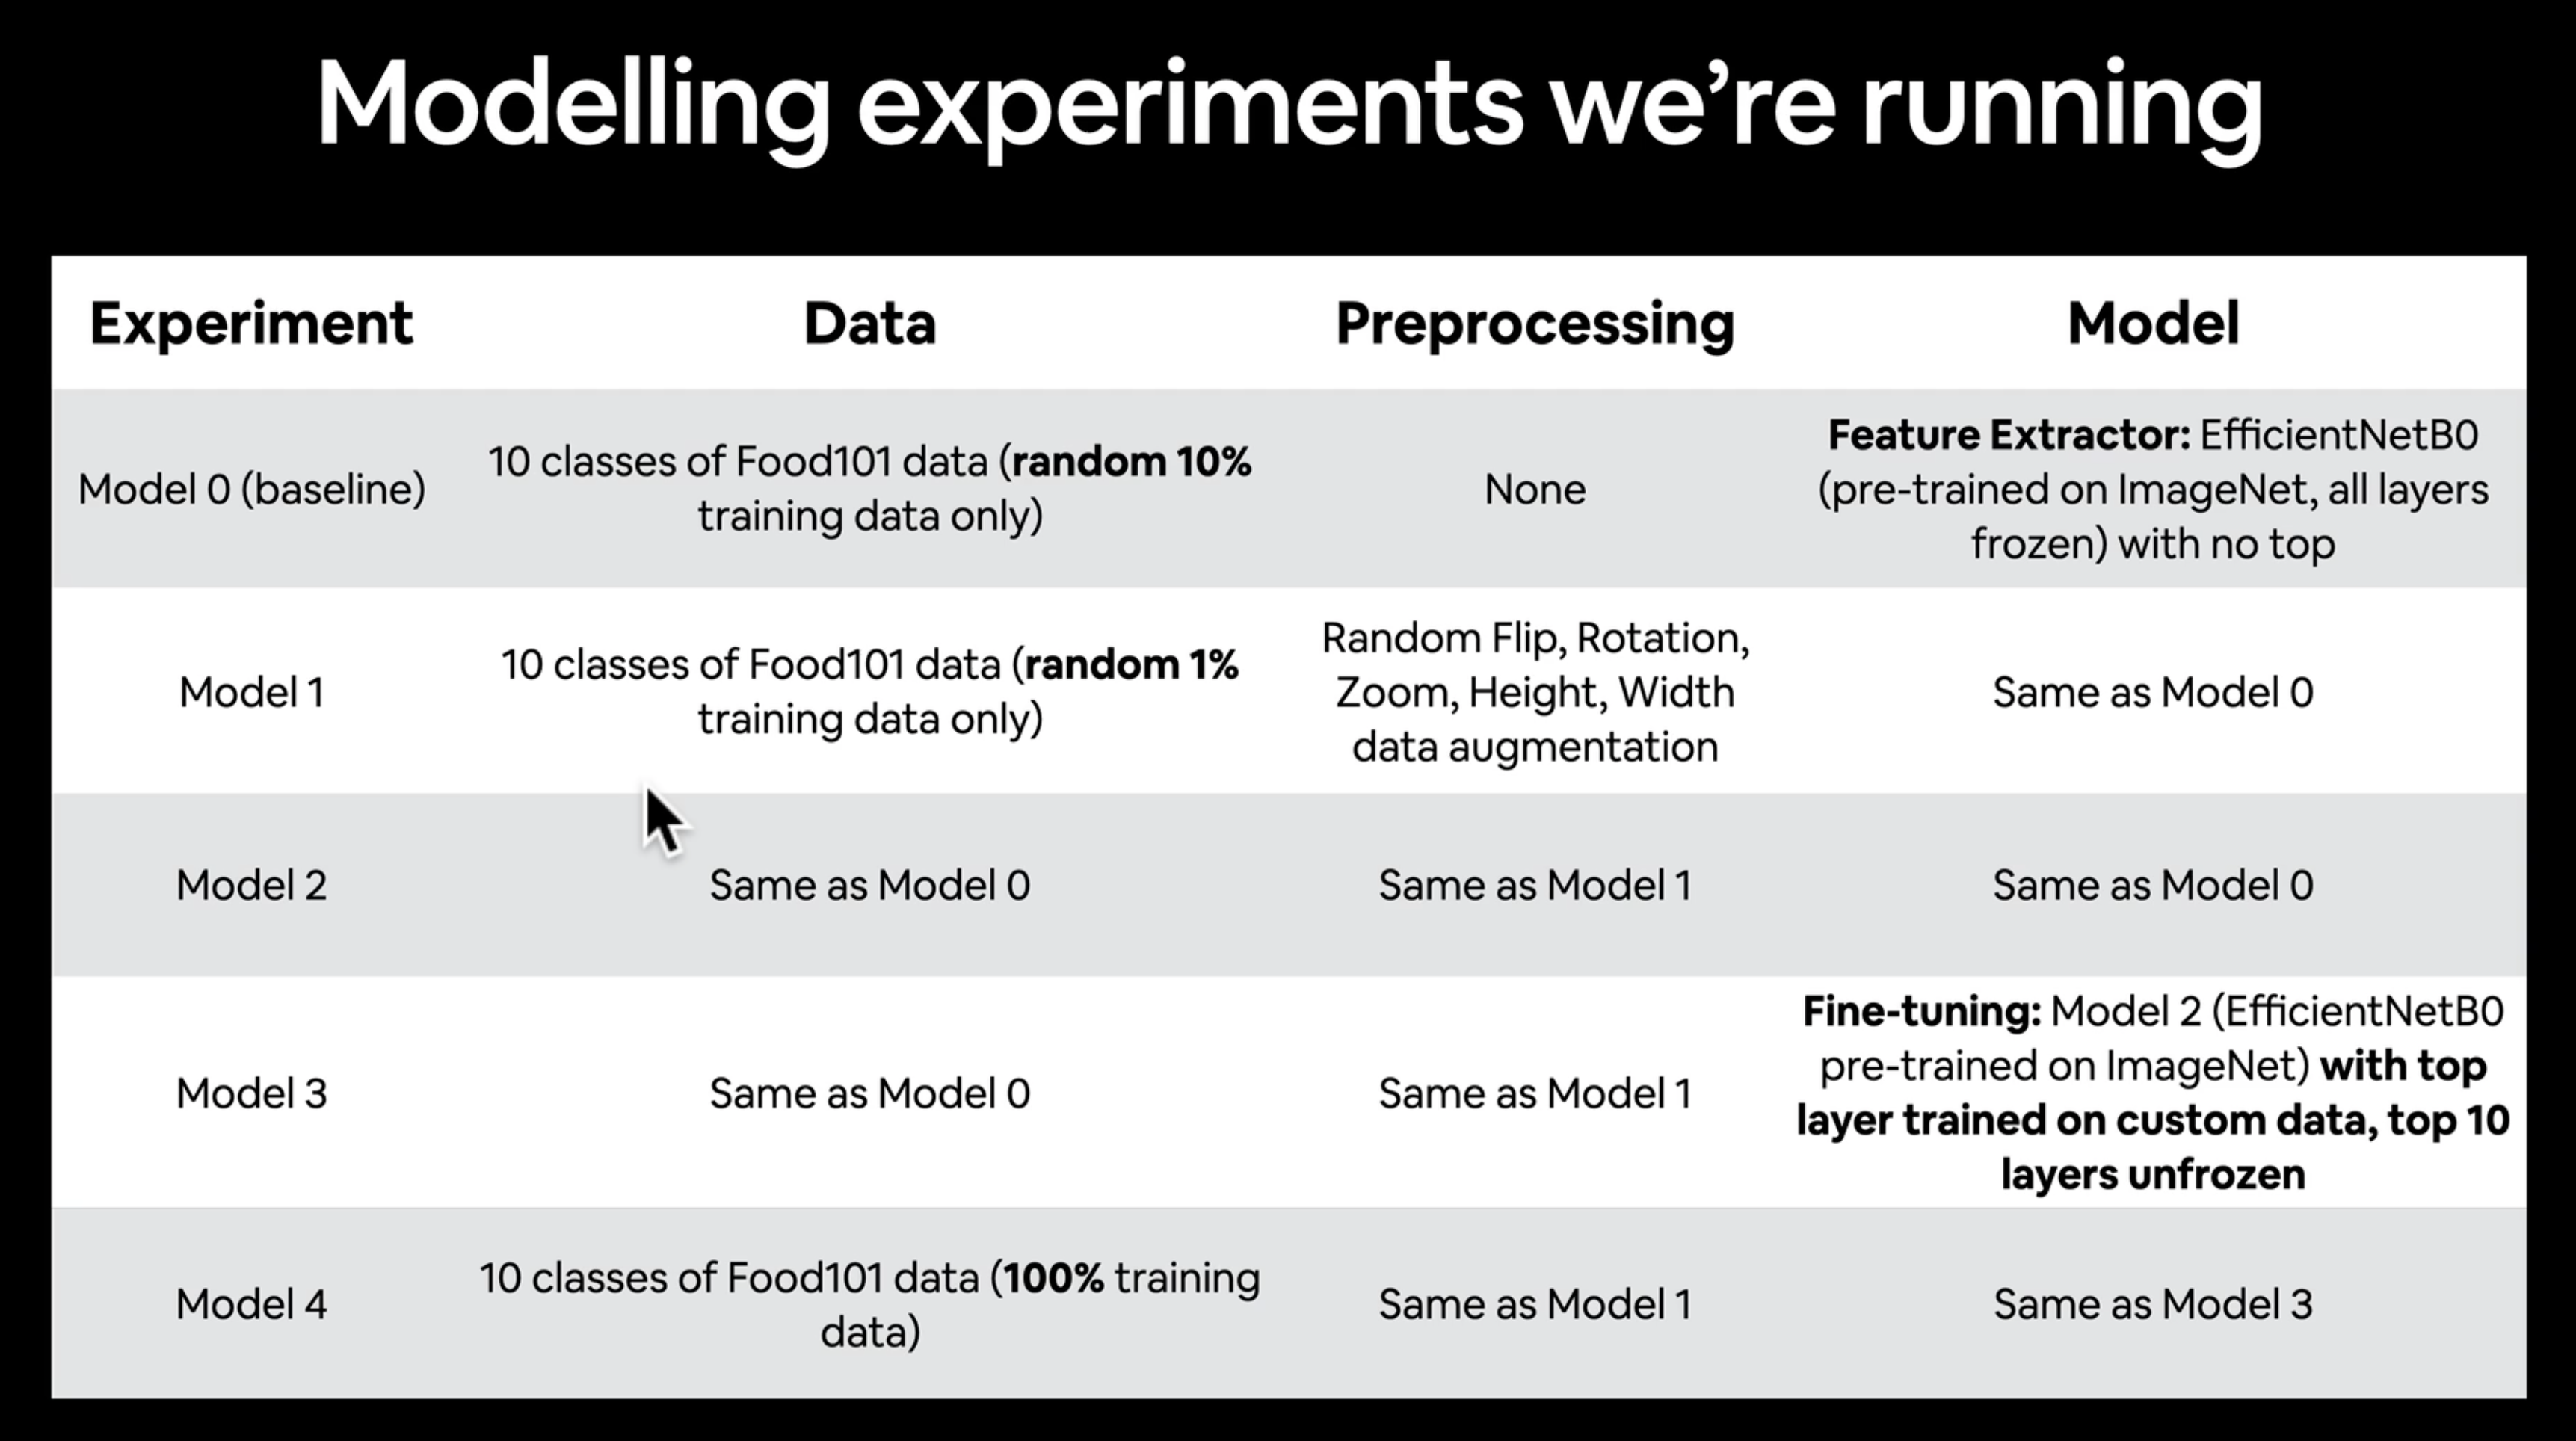

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the funcional API gives us more flexibility with our models.

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')

# 4. If using ResNet50V2, you will NEED to normalize inputs (You don't have to do this for EfficientNet)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing input through base mode: {x.shape}')

# 6. Average pool the outputs of the base model(aggreagate the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=create_tensorboard_callback(dir_name='transfer_learning',
                                                              experiment_name='10_percent_feature_extraction'))

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing input through base mode: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210804-131527
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 260ms/step - loss: 1.8697 - accuracy: 0.4147 - val_loss: 1.3565 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - 5s 187ms/step - loss: 1.1371 - accuracy: 0.7267 - val_loss: 0.9510 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 4s 166ms/step - loss: 0.8377 - accuracy: 0.8107 - val_loss: 0.7559 - val_accuracy: 0.8059
Epoch 4/5
24/24 [==============================] - 5s 186ms/step - loss: 0.6922 - accuracy: 0.8440 - val_loss: 0.6743 - val_accuracy: 0.8191
Epoch 5/5
24/24 [==============================] - 4s 163ms/step - loss: 0.5885 - accuracy: 0.8533 - val_loss: 0.6344 - val_accuracy: 0.8174


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 90ms/step - loss: 0.6115 - accuracy: 0.8360


[0.6115055084228516, 0.8360000252723694]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


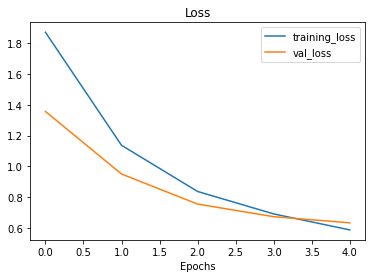

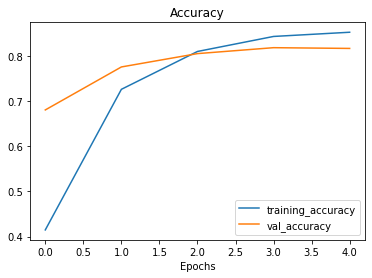

In [16]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained model
Let's demonstrate the Global Average Pooling layer...  

We have a tensor after our model goes through `base_model` of shape `(None, 7, 7, 1280)`...  

But then when it passes through `GlobalAveragePooing2D`, it turns into `(None, 1280)`.  

Let's use a similar shaped tensor of `(1, 4, 4, 3)` and then pass it to the `GlobalAveragePooling2D`

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Averaged Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Averaged Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [19]:
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global max pooling layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f'2D global max pooled random tensor:\n {global_max_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


## Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> Same test dataset to ensure consistency

### Getting and preprocessing data for model_1

In [20]:
# Download and unzip data (preprocess from food 101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2021-08-04 13:16:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   207MB/s    in 0.6s    

2021-08-04 13:16:25 (207 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# Create training aand test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir_1_percent = '10_food_classes_1_percent/test'

In [22]:
# How many images are we working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

In [23]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into the model, we can use the layers inside:

* `tf.keras.layers.preprocessing`

The advantages of data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # Keep this for models like ResNet50V2 but EfficientNet has rescaling built-in
], name='data_augmentation')

### Visualize the data augmentation layer

Text(0.5, 1.0, 'augmented random image from class: steak')

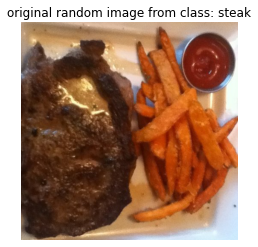

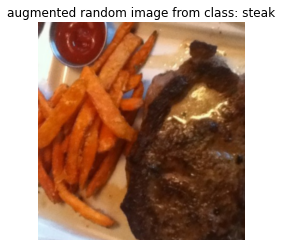

In [25]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir ='10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(f'original random image from class: {target_class}')

# Now plot the augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze(augmented_img)
plt.figure()
plt.imshow(augmented_img/255)
plt.axis(False)
plt.title(f'augmented random image from class: {target_class}')

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Setup th einput shape and base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after agumentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning', experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210804-131629


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4492 - accuracy: 0.0286 - val_loss: 2.2420 - val_accuracy: 0.1332
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1641 - accuracy: 0.2000 - val_loss: 2.1197 - val_accuracy: 0.2352
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.0033 - accuracy: 0.3286 - val_loss: 2.0096 - val_accuracy: 0.3257
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8157 - accuracy: 0.5143 - val_loss: 1.9154 - val_accuracy: 0.4194
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6888 - accuracy: 0.5857 - val_loss: 1.8324 - val_accuracy: 0.4720


In [27]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [28]:
model_1.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 1.8290 - accuracy: 0.4616


[1.8289974927902222, 0.46160000562667847]

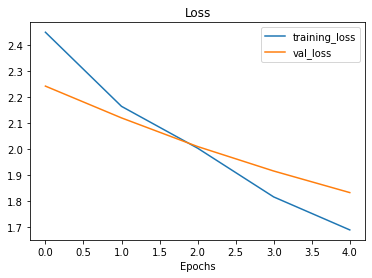

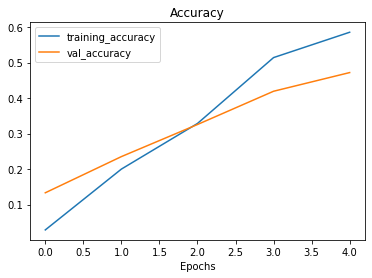

In [29]:
plot_loss_curves(history_1)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [30]:
# Get 10 percent of data
train_dir_10_percent = '10_food_classes_10_percent/train/'
test_dir_10_percent = '10_food_classes_10_percent/test/'

In [31]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [33]:
# Rewrite data augmentation layer
my_data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name='data_augmentation')

In [34]:
# Create model 2
input_shape = (224, 224, 3)

inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Createing a `ModelCheckpoint` callback
The `ModelCheckpoint` callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [36]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # Save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [37]:
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning', experiment_name='10_percent_data_aug'), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210804-131705
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 372ms/step - loss: 2.0320 - accuracy: 0.3187 - val_loss: 1.5190 - val_accuracy: 0.6184

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 6s 235ms/step - loss: 1.3669 - accuracy: 0.6560 - val_loss: 1.0578 - val_accuracy: 0.7516

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 6s 255ms/step - loss: 1.0866 - accuracy: 0.7160 - val_loss: 0.8607 - val_accuracy: 0.7977

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 6s 240ms/step - loss: 0.9189 - accuracy: 0.7627 - val_loss: 0.7587 - val_accuracy: 0.7977

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 6s 233ms/step - loss: 0.8100 - accuracy: 0.7813 - val_loss

In [38]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.6115 - accuracy: 0.8360


[0.6115054488182068, 0.8360000252723694]

In [39]:
model_2.evaluate(test_data), model_2.metrics_names

79/79 [==============================] - 7s 88ms/step - loss: 0.6916 - accuracy: 0.8164


([0.6915546655654907, 0.8163999915122986], ['loss', 'accuracy'])

In [40]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


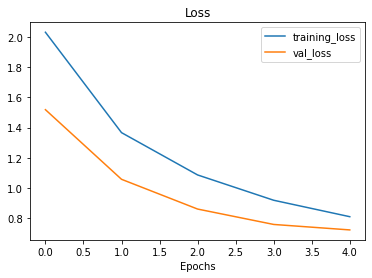

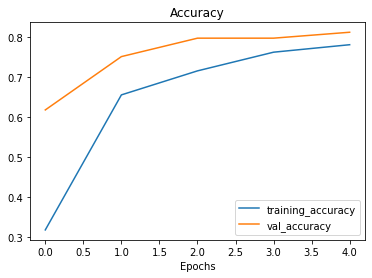

In [41]:
plot_loss_curves(history_2)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint

In [42]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [43]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results

79/79 [==============================] - 7s 88ms/step - loss: 0.6916 - accuracy: 0.8164


[0.6915543675422668, 0.8163999915122986]

## Model 3: Fine tuning an existing model on 10% of the data
> **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [44]:
# Layers in loaded model
model_2.layers

In [45]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd253dc2d90> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fd33071a1d0> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7fd330166250> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd253dc2e10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fd253dc2fd0> True


In [46]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [47]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# Start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model everytime a change is made
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

> When fine-tuning you typically want to lower the learning rate by 10x compared to default.

In [49]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [50]:
# How many trainable variable are there now?
print(len(model_2.trainable_variables))

12


In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2) except with more trainable layers
history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1], # Start training from previous last epoch
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning', experiment_name='10_percent_fine_tune_last_10')]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210804-131830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
24/24 [==============================] - 14s 339ms/step - loss: 0.6939 - accuracy: 0.7840 - val_loss: 0.5706 - val_accuracy: 0.8174
Epoch 6/10
24/24 [==============================] - 6s 231ms/step - loss: 0.5457 - accuracy: 0.8347 - val_loss: 0.5007 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 6s 243ms/step - loss: 0.5036 - accuracy: 0.8427 - val_loss: 0.5003 - val_accuracy: 0.8207
Epoch 8/10
24/24 [==============================] - 6s 224ms/step - loss: 0.4587 - accuracy: 0.8533 - val_loss: 0.4683 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 6s 233ms/step - loss: 0.4111 - accuracy: 0.8813 - val_loss: 0.4743 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 6s 236ms/step - loss: 0.3389 - accuracy: 0.9040 - val_loss: 0.4706 - val_accuracy: 0.8355


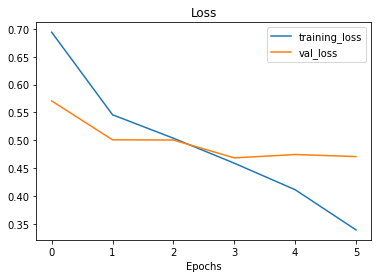

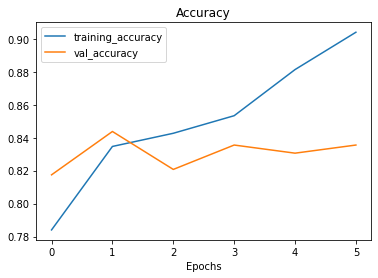

In [52]:
plot_loss_curves(history_3)

In [53]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 92ms/step - loss: 0.4951 - accuracy: 0.8392


In [54]:
# Create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
  '''
  Compares 2 TensorFlow History objects
  '''
  # Get original historyy measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Trainig accuracy")
  plt.plot(total_val_acc, label="Validation accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Trainig loss")
  plt.plot(total_val_loss, label="Validation loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')

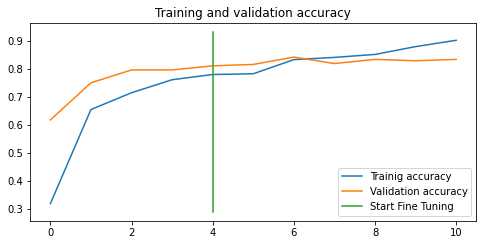

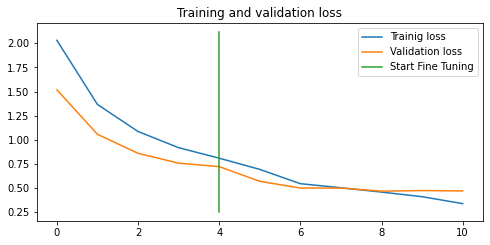

In [55]:
compare_history(history_2,
                history_3,
                initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [56]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2021-08-04 13:19:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   261MB/s    in 1.9s    

2021-08-04 13:19:43 (261 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [57]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [58]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [59]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [60]:
# Prepare the model
model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.4951 - accuracy: 0.8392


[0.49508389830589294, 0.8392000198364258]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature extravtion weights

In [61]:
# Load weights from checkpoint, that we can fine-tune from the same stage
# the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [62]:
# Evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.6916 - accuracy: 0.8164


[0.6915544867515564, 0.8163999915122986]

In [63]:
# Check the tunable layers in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [64]:
# See the tunable layers in the base_model
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [65]:
# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [66]:
# Continue to train and finr-tune the model to our data (100% of traing data)
fine_tune_epochs = initial_epochs + 5
history_4 = model_2.fit(train_all_data,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='full_10_classes_fine_tune')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20210804-132008
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 42s 156ms/step - loss: 0.7324 - accuracy: 0.7620 - val_loss: 0.4051 - val_accuracy: 0.8628
Epoch 6/10
235/235 [==============================] - 39s 162ms/step - loss: 0.5854 - accuracy: 0.8121 - val_loss: 0.3654 - val_accuracy: 0.8808
Epoch 7/10
235/235 [==============================] - 37s 156ms/step - loss: 0.5217 - accuracy: 0.8344 - val_loss: 0.3316 - val_accuracy: 0.8900
Epoch 8/10
235/235 [==============================] - 35s 149ms/step - loss: 0.4726 - accuracy: 0.8473 - val_loss: 0.3305 - val_accuracy: 0.8924
Epoch 9/10
235/235 [==============================] - 35s 149ms/step - loss: 0.4331 - accuracy: 0.8592 - val_loss: 0.3087 - val_accuracy: 0.8996
Epoch 10/10
235/235 [==============================] - 35s 149ms/step - loss: 0.4058 - accuracy: 0.8713 - val_loss: 0.3001 - val_accuracy: 0.9084


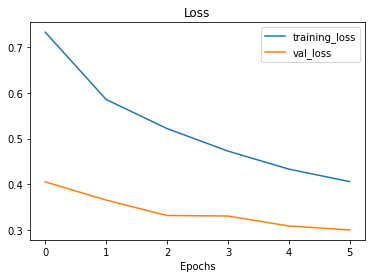

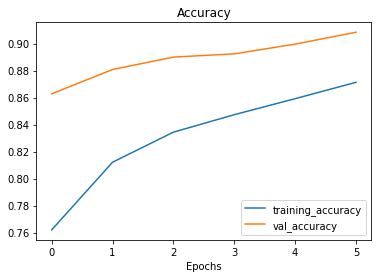

In [67]:
plot_loss_curves(history_4)

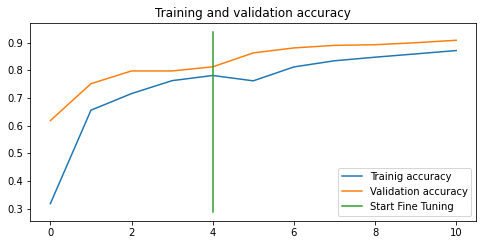

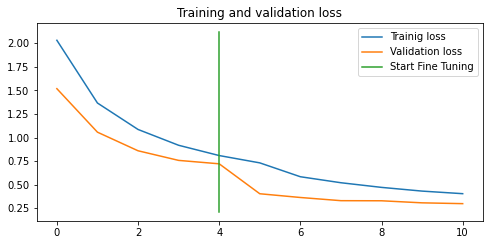

In [68]:
compare_history(history_2, history_4)

In [69]:
results_fine_tune_all_data = model_2.evaluate(test_data)

79/79 [==============================] - 7s 90ms/step - loss: 0.3001 - accuracy: 0.9084


## Viewing experiment data on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name 'Transfer Learning Experiments with 10 Food101 Classes' \
--description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
--one_shot # exit uploader once finished

In [73]:
!tensorboard dev list

2021-08-04 13:37:17.528031: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/rYoGRw4LRrCLT2xRhNizTw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   rYoGRw4LRrCLT2xRhNizTw
	Created              2021-08-04 13:31:03 (6 minutes ago)
	Updated              2021-08-04 13:31:08 (6 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4216973
https://tensorboard.dev/experiment/kC0EMPAnS86kKb0GEPzPUA/
	Name                 EfficientNetB0 vs. ResNet 50V2
	Description          Comparing 2 different TF Hub feature extraction model architectures using 10% of the training data
	Id                   kC0EMPAnS86kKb0GEPzPUA
	Created              2021-08-02

In [74]:
!tensorboard dev delete --experiment_id kC0EMPAnS86kKb0GEPzPUA

2021-08-04 13:38:18.140015: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Deleted experiment kC0EMPAnS86kKb0GEPzPUA.


In [75]:
!tensorboard dev list

2021-08-04 13:38:28.678965: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/rYoGRw4LRrCLT2xRhNizTw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   rYoGRw4LRrCLT2xRhNizTw
	Created              2021-08-04 13:31:03 (7 minutes ago)
	Updated              2021-08-04 13:31:08 (7 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4216973
Total: 1 experiment(s)


## Practice
* Use EfficientNetB7
* Fine tune 20 layers
* 100% of the data

In [77]:
IMG_SIZE = (224, 224)
train_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [94]:
base_model_2 = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_2.trainable = False

In [95]:
inputs_2 = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs_2)
x = base_model_2(inputs_2)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs_2 = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_5 = tf.keras.Model(inputs_2, outputs_2)

In [96]:
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_5 = model_5.fit(train_all_data,
                        epochs=5,
                        steps_per_epoch=len(train_all_data),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='efficientnet_b7_practice')])

Saving TensorBoard log files to: transfer_learning/efficientnet_b7_practice/20210804-140911


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
235/235 [==============================] - 93s 323ms/step - loss: 0.7735 - accuracy: 0.7741 - val_loss: 0.4121 - val_accuracy: 0.8750
Epoch 2/5
235/235 [==============================] - 75s 316ms/step - loss: 0.4987 - accuracy: 0.8417 - val_loss: 0.3696 - val_accuracy: 0.8898
Epoch 3/5
235/235 [==============================] - 70s 294ms/step - loss: 0.4346 - accuracy: 0.8628 - val_loss: 0.3609 - val_accuracy: 0.8865
Epoch 4/5
235/235 [==============================] - 74s 315ms/step - loss: 0.3961 - accuracy: 0.8751 - val_loss: 0.3213 - val_accuracy: 0.9030
Epoch 5/5
235/235 [==============================] - 70s 295ms/step - loss: 0.3598 - accuracy: 0.8888 - val_loss: 0.3165 - val_accuracy: 0.9030


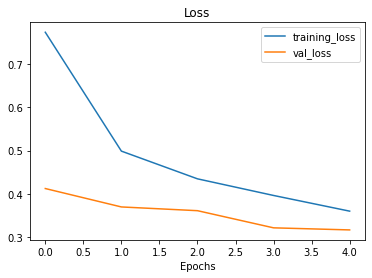

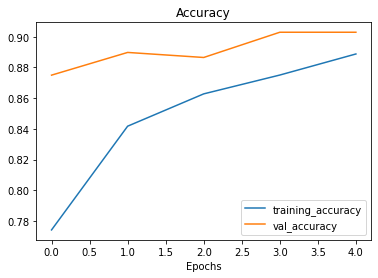

In [98]:
plot_loss_curves(history_5)

In [99]:
model_5.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling_layer (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                25610     
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
_________________________________________________________________


In [100]:
model_5.evaluate(test_data)

79/79 [==============================] - 21s 265ms/step - loss: 0.3176 - accuracy: 0.8976


[0.3175748884677887, 0.897599995136261]

In [101]:
model_5.layers

In [116]:
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [119]:
model_5.layers[1].trainable = True

In [120]:
len(model_5.layers[1].trainable_variables)

709

In [123]:
for layer in model_5.layers[1].layers[:-20]:
  layer.trainable = False
for i, layer in enumerate(model_5.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_12 False
1 rescaling_12 False
2 normalization_11 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop 

In [127]:
len(model_5.trainable_variables)

16

In [128]:
history_2.epoch

[0, 1, 2, 3, 4]

In [130]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_6 = model_5.fit(train_all_data, epochs=fine_tune_epochs,
                        validation_data=test_data,
                        initial_epoch=history_2.epoch[-1],
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='efficientnet_b7')])

Saving TensorBoard log files to: transfer_learning/efficientnet_b7/20210804-144139


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
235/235 [==============================] - 97s 344ms/step - loss: 0.3982 - accuracy: 0.8727 - val_loss: 0.3537 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 69s 292ms/step - loss: 0.4057 - accuracy: 0.8689 - val_loss: 0.3986 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 74s 313ms/step - loss: 0.4040 - accuracy: 0.8664 - val_loss: 0.3905 - val_accuracy: 0.8734
Epoch 8/10
235/235 [==============================] - 69s 294ms/step - loss: 0.4056 - accuracy: 0.8656 - val_loss: 0.3694 - val_accuracy: 0.8783
Epoch 9/10
235/235 [==============================] - 69s 293ms/step - loss: 0.4000 - accuracy: 0.8685 - val_loss: 0.3960 - val_accuracy: 0.8701
Epoch 10/10
235/235 [==============================] - 69s 292ms/step - loss: 0.4022 - accuracy: 0.8681 - val_loss: 0.3502 - val_accuracy: 0.8783


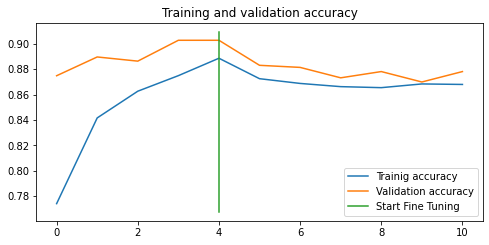

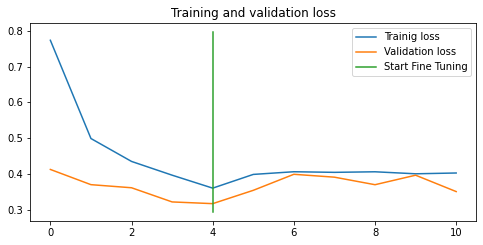

In [131]:
compare_history(history_5, history_6)

Proof that fine-tuning **doesn't always** work, the above graphs shows that the model is overfitting / not improving